In [1]:
import numpy as np
import tensorflow as tf
import time

E:\Anaconda3\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../../data/MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../data/MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../data/MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ../../data/MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ../../data/MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [4]:
print(mnist.test.labels.shape)

(10000, 10)


In [5]:
print(mnist.train.labels.shape)

(55000, 10)


In [6]:
def weight_var(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

In [7]:
def bias_var(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [8]:
def con2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

In [9]:
def max_pool(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

In [10]:
with tf.name_scope('placeholder'):
    X_input = tf.placeholder(tf.float32, [None, 784])
    y_input = tf.placeholder(tf.float32, [None, 10])

In [11]:
with tf.name_scope('conv1'):
    x = tf.reshape(X_input, [-1, 28, 28, 1])
    W1 = weight_var([5, 5, 1, 32])
    b1 = bias_var([32])
    h_conv1 = tf.nn.relu(con2d(x, W1) + b1)

In [12]:
print(h_conv1.shape)

(?, 28, 28, 32)


In [13]:
with tf.name_scope('max_pool1'):
    h_pool1 = max_pool(h_conv1)
    print(h_pool1.shape)

(?, 14, 14, 32)


In [14]:
with tf.name_scope('conv2'):
    W2 = weight_var([5, 5, 32, 64])
    b2 = bias_var([64])
    h_conv2 = tf.nn.relu(con2d(h_pool1, W2) + b2)
    print(h_conv2.shape)

(?, 14, 14, 64)


In [15]:
with tf.name_scope('max_pool2'):
    h_pool2 = max_pool(h_conv2)
    print(h_pool2.shape)

(?, 7, 7, 64)


In [16]:
h_flat = tf.reshape(h_pool2, [-1, 7*7*64])
print(h_flat.shape)

(?, 3136)


In [17]:
with tf.name_scope('ReLU1'):
    w3 = weight_var([7*7*64, 1024])
    b3 = bias_var([1024])
    h_fc1 = tf.nn.relu(tf.matmul(h_flat, w3) + b3)
    print(h_fc1.shape)

(?, 1024)


In [18]:
with tf.name_scope('dropout'):
    keep_prob = tf.placeholder(tf.float32)
    h_drop1 = tf.nn.dropout(h_fc1, keep_prob=keep_prob)
    print(h_drop1.shape)

(?, 1024)


In [19]:
with tf.name_scope('softmax'):
    w4 = weight_var([1024, 10])
    b4 = bias_var([10])
    y_pred = tf.nn.softmax(tf.matmul(h_drop1, w4) + b4)

In [20]:
print(y_pred.shape)

(?, 10)


In [21]:
with tf.name_scope('cross_entropy'):
    cross_entropy = -tf.reduce_sum(y_input * tf.log(y_pred))
    tf.summary.scalar('cross_entropy',cross_entropy)

In [22]:
with tf.name_scope('AdamOptimizer'):
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

In [23]:
with tf.name_scope('accuracy'):
    correct_pred = tf.equal(tf.argmax(y_pred,1), tf.argmax(y_input,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, 'float'))
    tf.summary.scalar('accuracy',accuracy)

In [24]:
with tf.name_scope('FileWriter'):
    merged = tf.summary.merge_all()
    sess.run(tf.global_variables_initializer())
    train_writer = tf.summary.FileWriter('./log', sess.graph)

In [25]:
with tf.name_scope('train'):
    t0 = time.time()
    for i in range(200):
        x_batch, y_batch = mnist.train.next_batch(batch_size=64)
        summary, cost, acc, _ = sess.run([merged, cross_entropy, accuracy, train_step], feed_dict={X_input:x_batch, y_input:y_batch, keep_prob:0.5})
        if (i+1)%50 == 0:
            train_writer.add_summary(summary,i)
            test_cost, test_acc = sess.run([cross_entropy, accuracy], feed_dict={X_input: mnist.test.images, y_input: mnist.test.labels, keep_prob: 1.0})
            print("step {}, train cost={:.6f}, acc={:.6f}; test cost={:.6f}, acc={:.6f}".format(i+1, cost, acc, test_cost, test_acc))
            print("time={}".format(time.time() - t0))
            t0 = time.time()
    train_writer.close()

step 50, train cost=192.050827, acc=0.312500; test cost=9279.921875, acc=0.683100
time=19.716103553771973
step 100, train cost=62.121265, acc=0.734375; test cost=5097.155273, acc=0.848800
time=14.866443395614624
step 150, train cost=46.353477, acc=0.828125; test cost=3782.224854, acc=0.889700
time=13.392112731933594
step 200, train cost=34.103149, acc=0.781250; test cost=3199.362793, acc=0.907400
time=14.167714357376099


In [26]:
img1 = mnist.train.images[0]
label1 = mnist.train.labels[0]
print(label1)

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [27]:
img1 = img1.reshape([28, 28])
print(img1.shape)

(28, 28)


In [28]:
import matplotlib.pyplot as plt
plt.imshow(img1)
plt.axis('off')
plt.show()

<Figure size 640x480 with 1 Axes>

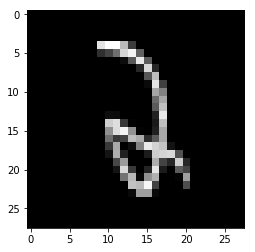

In [29]:
plt.imshow(img1, cmap='gray')
plt.show()

In [30]:
x_img1 = img1.reshape([-1, 784])
print(x_img1.shape)

(1, 784)


In [31]:
y_label1 = mnist.train.labels[1].reshape([-1,10])
print(y_label1.shape)

(1, 10)


In [32]:
result = sess.run([h_conv1], feed_dict={X_input:x_img1, y_input:y_label1, keep_prob:1.0})

In [33]:
print(len(result))
print(result[0].shape)
result_conv1 = result[0]

1
(1, 28, 28, 32)


In [34]:
print(result_conv1[:,:,:,1].shape)

(1, 28, 28)


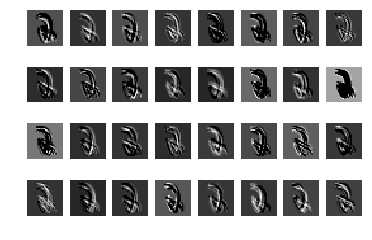

In [35]:
for i in range(32):
    show_img = result_conv1[:,:,:,i]
    show_img = show_img.reshape([28, 28])
    plt.subplot(4, 8, i+1)
    plt.imshow(show_img, cmap='gray')#
    plt.axis('off')
plt.show()